In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats

In [10]:
# Change data paths to your own
metadata = pd.read_csv("../../Data/processed/processed_metadata.txt", sep="\t")
cluster_labels = pd.read_csv("./TSNE_clustering_labels_df.tsv", sep="\t")

# Choose which method to use for clustering if you df has multiple clustering method labels
cluster_labels = cluster_labels.loc[:, ["sample_id", "kmeans_cluster_label"]]
t = np.linspace(0, 1800, 1801)

In [11]:
# reomve metastatic samples
filtered_cluster_labels = cluster_labels[cluster_labels["sample_id"].apply(lambda x: not x.split('-')[3].startswith("06"))]

# Extract patient IDs
filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]
filtered_cluster_labels = filtered_cluster_labels.rename(columns={"kmeans_cluster_label": "cluster"})
df = pd.merge(filtered_cluster_labels, metadata, on='patient_id')
df = df.drop(columns=["sample_id"])

/tmp/ipykernel_2817135/1543921108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]


In [25]:
np.count_nonzero(df['OS_time'] > 1750)

65

In [26]:
np.count_nonzero(df['DSS_time'] > 1750)

65

   test_statistic         p  -log2(p)
0        4.846272  0.088643  3.495846


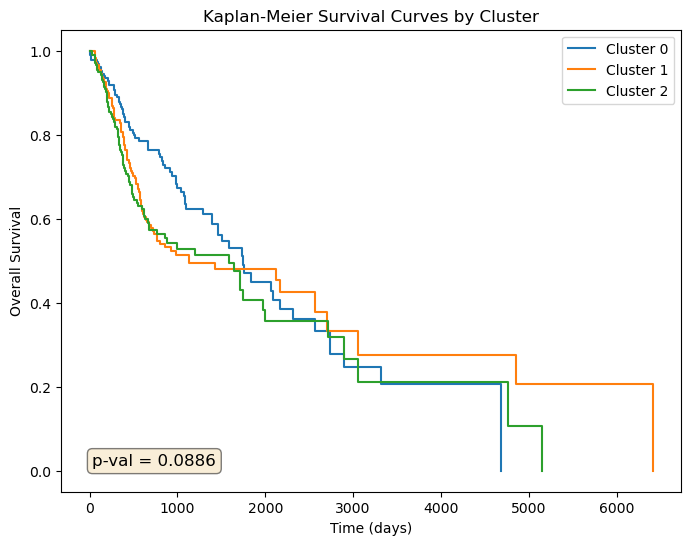

<lifelines.CoxPHFitter: fitted with 543 total observations, 295 right-censored observations>
             duration col = 'OS_time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 543
number of events observed = 248
   partial log-likelihood = -1364.74
         time fit was run = 2025-04-17 22:30:18 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1  0.23      1.26      0.16           -0.08            0.54                0.92                1.71
cluster_2  0.34      1.41      0.16            0.03            0.65                1.03                1.92

           cmp to    z    p  -log2(p)
covariate                            
cluster_1    0.00 1.45 0.15      2.78
cluster_2    0.00 2.16 0.03      5.03
---
Concordance = 0.56
Partial AIC = 2733.49
log-likelihood ratio test = 4.89 on 2 df
-log2(p) of ll-ratio test = 3.53

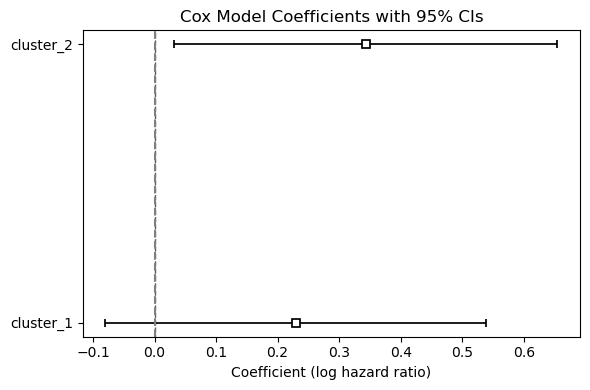

In [22]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization for OS
# -------------------------------------------------
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df.groupby('cluster'):
    kmf.fit(cluster_df['OS_time'], event_observed=cluster_df['OS'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df['OS_time'], df['cluster'], event_observed=df['OS'])

print(logrank_results.summary)

plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.xlabel("Time (days)")
plt.ylabel("Overall Survival")
plt.legend()

ax = plt.gca()
ax.text(0.05, 0.05, f"p-val = {logrank_results.p_value:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
df['cluster'] = df['cluster'].astype(str)
df_encoded = pd.get_dummies(df[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df[['OS_time', 'OS']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, timeline=t, duration_col='OS_time', event_col='OS')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values

plt.figure(figsize=(6, 4))
cph.plot()
plt.title("Cox Model Coefficients with 95% CIs")
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Coefficient (log hazard ratio)")
plt.tight_layout()
plt.show()

   test_statistic         p  -log2(p)
0        7.492706  0.023604  5.404845


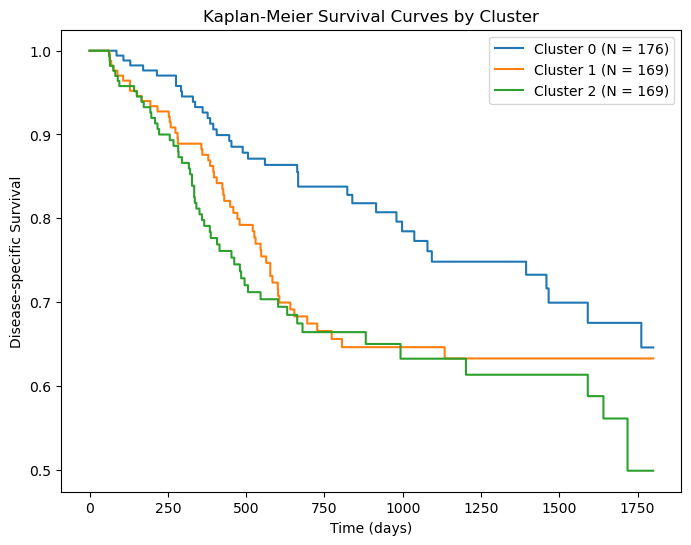

<lifelines.CoxPHFitter: fitted with 514 total observations, 365 right-censored observations>
             duration col = 'DSS_time'
                event col = 'DSS'
      baseline estimation = breslow
   number of observations = 514
number of events observed = 149
   partial log-likelihood = -835.23
         time fit was run = 2025-04-17 22:24:40 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1  0.38      1.47      0.21           -0.02            0.79                0.98                2.21
cluster_2  0.56      1.74      0.21            0.15            0.96                1.16                2.62

           cmp to    z    p  -log2(p)
covariate                            
cluster_1    0.00 1.85 0.06      3.95
cluster_2    0.00 2.68 0.01      7.08
---
Concordance = 0.58
Partial AIC = 1674.47
log-likelihood ratio test = 7.65 on 2 df
-log2(p) of ll-ratio test = 5.52

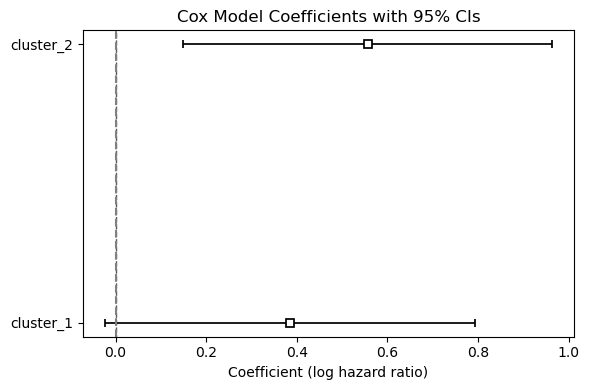

In [20]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization for DSS
# -------------------------------------------------
df_clean = df.dropna(subset=['DSS'])

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df_clean.groupby('cluster'):
    kmf.fit(cluster_df['DSS_time'], timeline=t, event_observed=cluster_df['DSS'], label=f'Cluster {cluster} (N = {cluster_df.shape[0]})')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df_clean['DSS_time'], df_clean['cluster'], event_observed=df_clean['DSS'])
print(logrank_results.summary)

plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.xlabel("Time (days)")
plt.ylabel("Disease-specific Survival")
plt.legend()
plt.plot([], [], ' ', label=f"p-value: {logrank_results.p_value:.4f} Hazard Ratio: {round(cph.summary['exp(coef)'].values[0], 3)}")

ax = plt.gca()
plt.show()


# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
#df_clean['cluster'] = df_clean['cluster'].astype(str)
df_encoded = pd.get_dummies(df_clean[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df_clean[['DSS_time', 'DSS']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, timeline=t, duration_col='DSS_time', event_col='DSS')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values

plt.figure(figsize=(6, 4))
cph.plot()
plt.title("Cox Model Coefficients with 95% CIs")
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Coefficient (log hazard ratio)")
plt.tight_layout()
plt.show()


   test_statistic        p  -log2(p)
0        3.375228  0.18496  2.434712


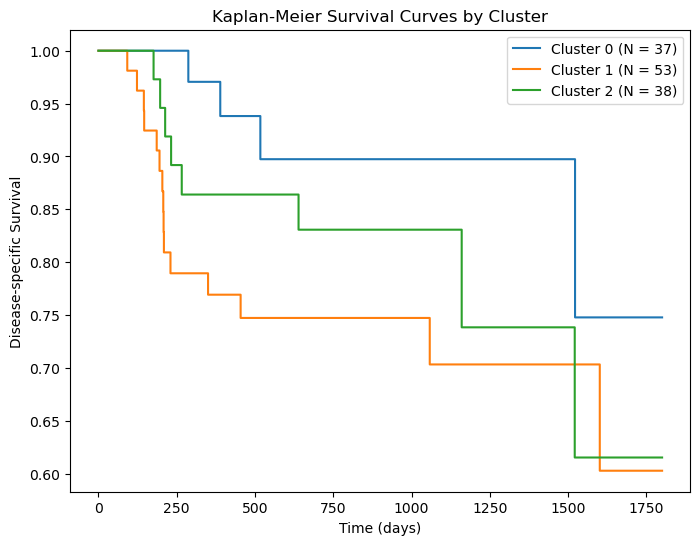

<lifelines.CoxPHFitter: fitted with 128 total observations, 100 right-censored observations>
             duration col = 'DFI_time'
                event col = 'DFI'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 28
   partial log-likelihood = -118.99
         time fit was run = 2025-04-17 22:24:41 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1  1.00      2.72      0.56           -0.10            2.10                0.90                8.20
cluster_2  0.77      2.17      0.60           -0.41            1.95                0.67                7.04

           cmp to    z    p  -log2(p)
covariate                            
cluster_1    0.00 1.77 0.08      3.72
cluster_2    0.00 1.29 0.20      2.33
---
Concordance = 0.63
Partial AIC = 241.97
log-likelihood ratio test = 3.76 on 2 df
-log2(p) of ll-ratio test = 2.71

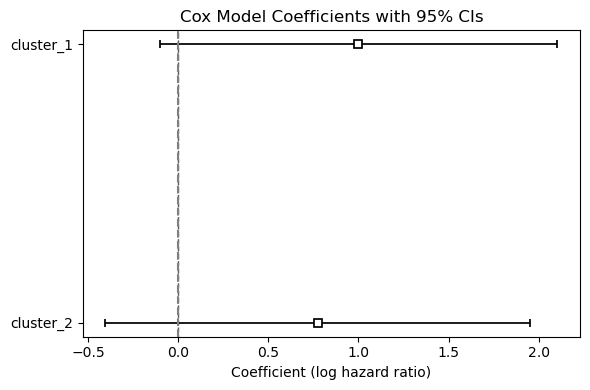

In [21]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization for DFI
# -------------------------------------------------
df_clean = df.dropna(subset=['DFI'])

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df_clean.groupby('cluster'):
    kmf.fit(cluster_df['DFI_time'], timeline=t, event_observed=cluster_df['DFI'], label=f'Cluster {cluster} (N = {cluster_df.shape[0]})')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df_clean['DFI_time'], df_clean['cluster'], event_observed=df_clean['DFI'])
print(logrank_results.summary)

plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.xlabel("Time (days)")
plt.ylabel("Disease-specific Survival")
plt.legend()
plt.plot([], [], ' ', label=f"p-value: {logrank_results.p_value:.4f} Hazard Ratio: {round(cph.summary['exp(coef)'].values[0], 3)}")

ax = plt.gca()
plt.show()

# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
#df_clean['cluster'] = df_clean['cluster'].astype(str)
df_encoded = pd.get_dummies(df_clean[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df_clean[['DFI_time', 'DFI']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, timeline=t, duration_col='DFI_time', event_col='DFI')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values

plt.figure(figsize=(6, 4))
cph.plot()
plt.title("Cox Model Coefficients with 95% CIs")
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Coefficient (log hazard ratio)")
plt.tight_layout()
plt.show()

In [17]:
logrank_results

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.38 0.18      2.43

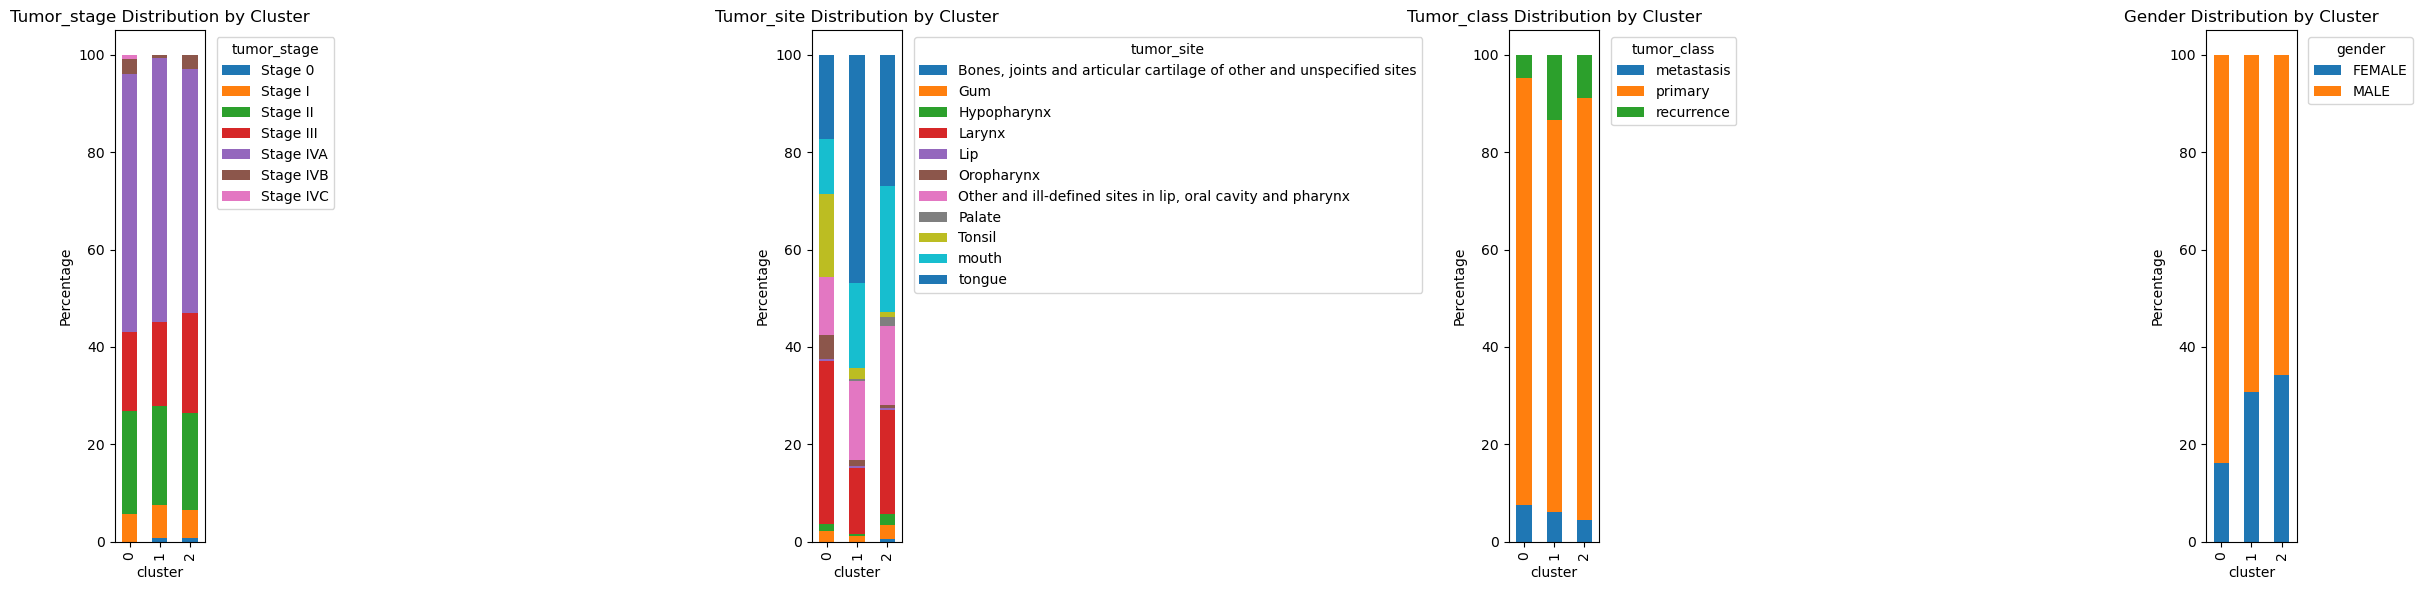

In [18]:
# ============================================================
# Creating Stacked Bar Plots for Each Categorical Variable
# ============================================================
# We will produce one stacked bar plot per variable.
# In each plot the x-axis corresponds to the groups (here: clusters)
# and the bars show the relative percentages of each category for the variable.

variables = ['tumor_stage', 'tumor_site', 'tumor_class', "gender"]

# Create one subplot per variable
fig, axes = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6))

# Iterate over the variables and plot each as a stacked bar chart
for ax, var in zip(axes, variables):
    # Create a contingency table of cluster vs the current variable.
    # The option normalize='index' computes the proportions within each cluster,
    # and multiplying by 100 converts those to percentages.
    ct = pd.crosstab(df['cluster'], df[var], normalize='index') * 100
    
    # Plot the stacked bar chart.
    ct.plot(kind='bar', stacked=True, ax=ax)
    
    # Set labels and title.
    ax.set_ylabel('Percentage')
    ax.set_title(f'{var.capitalize()} Distribution by Cluster')
    
    # Place the legend outside for better readability.
    ax.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout so the subplots don’t overlap.
plt.tight_layout()
plt.show()

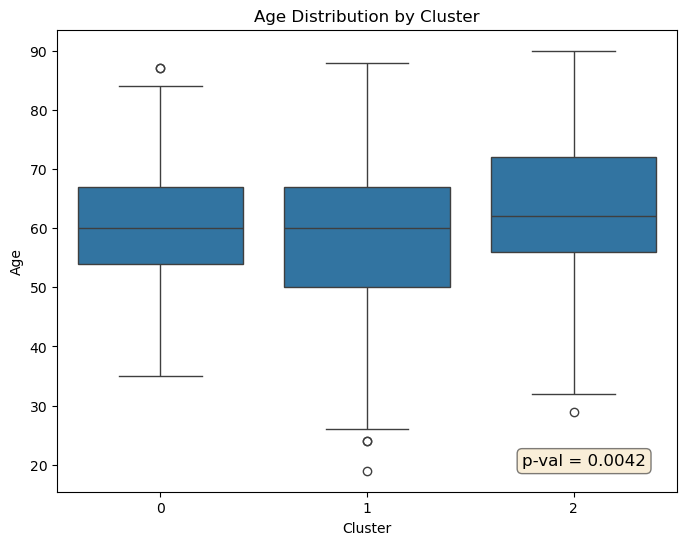

In [19]:
# ============================================================
# Create Boxplot: Age distribution by Cluster
# ============================================================
order = sorted(df['cluster'].unique())

groups = [df[df['cluster'] == cluster]['age'] for cluster in df['cluster'].unique()]
anova_result = stats.f_oneway(*groups)
p_val = anova_result.pvalue

plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='age', data=df, order=order)
plt.title('Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')

ax = plt.gca()
ax.text(0.95, 0.05, f"p-val = {p_val:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()